# Imports

In [23]:
import sys
sys.path.append('..')

In [59]:
# analysis
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

# local
import alignment.alignment_utils as utils

%matplotlib inline

In [25]:
def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# Params

In [28]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [29]:
DATA_PATH = '../data/results/decoding/'

In [30]:
phon_labels = ['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k']
artic_labels = ['low', 'high', 'labial', 'dorsal']
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [31]:
def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

# Data Visualization

### Plotting utils

In [32]:
px_colors = [
             '#636EFA',
             '#EF553B',
             '#AB63FA',
             '#00CC96',
            #  '#72B7B2',
            #  '#990099',
            #  '#B6E880',

             
            #  '#FFA15A',
            #  '#19D3F3',
            #  '#FF6692',
            #  '#B6E880',
            #  '#FF97FF',
            #  '#FECB52',
            ]

In [33]:
# sns.set_theme(context='notebook', font='Arial', font_scale=1.15)
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [34]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    cbar.outline.set_visible(False)

    sns.despine(left=True, bottom=True)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [36]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [37]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

### Panel a

In [280]:
pt_list = ['S14', 'S26', 'S33', 'S22', 'S23', 'S39', 'S58', 'S62']
pInd_list = [-1]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        
        p_tar = np.zeros((3, 50))
        p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'ptSpecific/{pt}/{pt}_{p_str}_ptSpecific_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/unaligned/{pt}_{p_str}_pooled_unaligned_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[2,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_{p_str}_pooled_ccaAlignedNew_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific', 'Unaligned cross-patient', 'Aligned cross-patient'])


        wide_dfs.append(decode_df)
        decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='accuracy')
        decode_df['Patient'] = paper_pt_dict[pt]
        decode_df['Phoneme Index'] = p_str
        cols = decode_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        decode_df = decode_df[cols]
        long_dfs.append(decode_df)
        
decode_df_wide = pd.concat(wide_dfs)
decode_df_long = pd.concat(long_dfs)

In [281]:
decode_df_long

,Phoneme Index,Decoding Context,accuracy,Patient
0,pAll,Patient-specific,0.398148,S1
1,pAll,Patient-specific,0.388889,S1
2,pAll,Patient-specific,0.379630,S1
3,pAll,Patient-specific,0.365741,S1
4,pAll,Patient-specific,0.370370,S1
...,...,...,...,...
145,pAll,Aligned cross-patient,0.314607,S8
146,pAll,Aligned cross-patient,0.346442,S8
147,pAll,Aligned cross-patient,0.335206,S8
148,pAll,Aligned cross-patient,0.346442,S8


In [ ]:
fig_ind = 'pAll'
fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind]
fig = px.box(fig_df, x='Patient', y="accuracy", color='Decoding Context', points='all', width=1000, height=600, color_discrete_sequence=['#636EFA', '#EF553B', '#AB63FA'])
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    title_text='',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='Target patient',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    tickvals=[0,1,2],
    range=[-0.5, 2.5]
)
fig.update_yaxes(
    title='Phoneme decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)

fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\tarPt_decoding_ptSplit.svg")
fig.show()

In [ ]:
pts = paper_pt_dict.values()
p_arr = np.zeros((len(pts), 3))
for i, pt in enumerate(pts):
    pt_spf = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Patient-specific')]['accuracy']
    pt_una = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Unaligned cross-patient')]['accuracy']
    pt_cca = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Aligned cross-patient')]['accuracy']

    stat, anova_p = stats.f_oneway(pt_spf, pt_una, pt_cca)
    res = stats.tukey_hsd(pt_spf, pt_una, pt_cca)
    cca_ps_p = res.pvalue[0,2]
    cca_una_p = res.pvalue[1,2]

    print(f'{pt}: ANOVA p = {anova_p}, CCA vs. PS p = {cca_ps_p}, CCA vs. Unaligned p = {cca_una_p}')
    print(f'ANOVA F-statistic: {stat}')
    print(res)

S1: ANOVA p = 1.888200647303227e-82, CCA vs. PS p = 2.398081733190338e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
ANOVA F-statistic: 877.4941393786721
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.086     0.000     0.080     0.093
 (0 - 2)     -0.025     0.000    -0.032    -0.019
 (1 - 0)     -0.086     0.000    -0.093    -0.080
 (1 - 2)     -0.112     0.000    -0.118    -0.105
 (2 - 0)      0.025     0.000     0.019     0.032
 (2 - 1)      0.112     0.000     0.105     0.118

S2: ANOVA p = 1.0799199629556557e-124, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
ANOVA F-statistic: 3498.4704872175507
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.159     0.000     0.153     0.166
 (0 - 2)     -0.058     0.000    -0.064    -0.051
 (1 - 0)     -0.159     0.000    -0.166    -0

In [79]:
fig_ind = 'pAll'
fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind].drop(columns=['Phoneme Index']).groupby(['Patient', 'Decoding Context'], sort=False).mean().reset_index()

fig = px.line(fig_df, x='Decoding Context', y="accuracy", color='Patient', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.add_traces(px.box(fig_df, x='Decoding Context', y="accuracy").data)
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    title_text='',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Phoneme decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)
fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\tarPt_decoding.svg")
fig.show()

In [63]:
fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind].drop(columns=['Phoneme Index']).groupby(['Patient', 'Decoding Context'], sort=False).mean().reset_index()
rm_df = fig_df.rename(columns={'Decoding Context': 'context'})

print(AnovaRM(data=rm_df, depvar='accuracy', subject='Patient', within=['context']).fit())

grp_spf = fig_df[fig_df['Decoding Context'] == 'Patient-specific']['accuracy']
grp_una = fig_df[fig_df['Decoding Context'] == 'Unaligned cross-patient']['accuracy']
grp_cca = fig_df[fig_df['Decoding Context'] == 'Aligned cross-patient']['accuracy']

grp_cca_ps_res = stats.ttest_rel(grp_cca, grp_spf)
grp_cca_una_res = stats.ttest_rel(grp_cca, grp_una)
grp_ps_una_res = stats.ttest_rel(grp_spf, grp_una)

print('##### Uncorrected Follow-up #####')
print(f'CCA vs. PS: {grp_cca_ps_res}')
print(f'CCA vs. Unaligned: {grp_cca_una_res}')
print(f'PS vs. Unaligned: {grp_ps_una_res}')

grp_p_arr = [grp_cca_ps_res.pvalue, grp_cca_una_res.pvalue, grp_ps_una_res.pvalue]

print('##### FDR Correction #####')
p_arr_corr = fdrcorrection(grp_p_arr)
print(f'CCA vs. PS: {p_arr_corr[1][0]}')
print(f'CCA vs. Unaligned: {p_arr_corr[1][1]}')
print(f'PS vs. Unaligned: {p_arr_corr[1][2]}')
print(f'Pass significance: {p_arr_corr[0]}')


                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
context 12.5894 2.0000 14.0000 0.0007

##### Uncorrected Follow-up #####
CCA vs. PS: TtestResult(statistic=3.066684532677714, pvalue=0.018151935612019873, df=7)
CCA vs. Unaligned: TtestResult(statistic=4.056559848488223, pvalue=0.004830556917769783, df=7)
PS vs. Unaligned: TtestResult(statistic=2.7276011414743966, pvalue=0.02944051046426378, df=7)
##### FDR Correction #####
CCA vs. PS: 0.02722790341802981
CCA vs. Unaligned: 0.014491670753309349
PS vs. Unaligned: 0.02944051046426378
Pass significance: [ True  True  True]


### Panel b

In [283]:
pt_list = ['S14', 'S26', 'S33', 'S22', 'S23', 'S39', 'S58', 'S62']
pInd_list = [-1]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        
        p_tar = np.zeros((3, 50))
        p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/unaligned/{pt}_{p_str}_pooled_unaligned_rbf_noTar_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_{p_str}_pooled_ccaAligned_rbf_noTar_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[2,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_{p_str}_pooled_ccaAligned_rbf_noTar_TME_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        decode_df = pd.DataFrame(p_tar.T, columns=['Unaligned', 'Aligned', 'Aligned (surrogate data)'])


        wide_dfs.append(decode_df)
        decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='accuracy')
        decode_df['Patient'] = paper_pt_dict[pt]
        decode_df['Phoneme Index'] = p_str
        cols = decode_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        decode_df = decode_df[cols]
        long_dfs.append(decode_df)
        
noTar_decode_df_wide = pd.concat(wide_dfs)
noTar_decode_df_long = pd.concat(long_dfs)

In [284]:
noTar_decode_df_long

,Phoneme Index,Decoding Context,accuracy,Patient
0,pAll,Unaligned,0.125000,S1
1,pAll,Unaligned,0.122685,S1
2,pAll,Unaligned,0.120370,S1
3,pAll,Unaligned,0.143519,S1
4,pAll,Unaligned,0.115741,S1
...,...,...,...,...
145,pAll,Aligned (surrogate data),0.129213,S8
146,pAll,Aligned (surrogate data),0.125468,S8
147,pAll,Aligned (surrogate data),0.119850,S8
148,pAll,Aligned (surrogate data),0.127341,S8


In [91]:
fig_ind = 'pAll'
fig_df = noTar_decode_df_long[decode_df_long['Phoneme Index'] == fig_ind]
fig = px.box(fig_df, x='Patient', y="accuracy", color='Decoding Context', points='all', width=1000, height=600, color_discrete_sequence=['#EF553B', '#AB63FA', '#19D3F3'])
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    title_text='',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='Target patient',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    tickvals=[0,1,2],
    range=[-0.5, 2.5]
)
fig.update_yaxes(
    title='Phoneme decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)

fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\noTar_decoding_ptSplit.svg")
fig.show()

In [100]:
pts = paper_pt_dict.values()
p_arr = np.zeros((len(pts), 3))
for i, pt in enumerate(pts):
    pt_una = noTar_decode_df_long[(noTar_decode_df_long['Patient'] == pt) & (noTar_decode_df_long['Decoding Context'] == 'Unaligned')]['accuracy']
    pt_cca = noTar_decode_df_long[(noTar_decode_df_long['Patient'] == pt) & (noTar_decode_df_long['Decoding Context'] == 'Aligned')]['accuracy']
    pt_cca_tme = noTar_decode_df_long[(noTar_decode_df_long['Patient'] == pt) & (noTar_decode_df_long['Decoding Context'] == 'Aligned (surrogate data)')]['accuracy']

    stat, anova_p = stats.f_oneway(pt_una, pt_cca, pt_cca_tme)
    res = stats.tukey_hsd(pt_una, pt_cca, pt_cca_tme)
    cca_una_p = res.pvalue[0,1]
    cca_tme_p = res.pvalue[1,2]

    print(f'{pt}: ANOVA p = {anova_p}, CCA vs. PS p = {cca_una_p}, CCA vs. Unaligned p = {cca_tme_p}')
    print(f'ANOVA F-statisitc: {stat}')
    print(res)

S1: ANOVA p = 2.658894066412616e-157, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
ANOVA F-statisitc: 9847.68425749872
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.234     0.000    -0.238    -0.230
 (0 - 2)     -0.058     0.000    -0.062    -0.054
 (1 - 0)      0.234     0.000     0.230     0.238
 (1 - 2)      0.176     0.000     0.172     0.180
 (2 - 0)      0.058     0.000     0.054     0.062
 (2 - 1)     -0.176     0.000    -0.180    -0.172

S2: ANOVA p = 1.5182334817695546e-189, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
ANOVA F-statisitc: 27169.110375881308
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.322     0.000    -0.326    -0.318
 (0 - 2)     -0.017     0.000    -0.021    -0.014
 (1 - 0)      0.322     0.000     0.318     

In [ ]:
fig_ind = 'pAll'
fig_df = noTar_decode_df_long[noTar_decode_df_long['Phoneme Index'] == fig_ind].drop(columns=['Phoneme Index']).groupby(['Patient', 'Decoding Context'], sort=False).mean().reset_index()

fig = px.line(fig_df, x='Decoding Context', y="accuracy", color='Patient', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.add_traces(px.box(fig_df, x='Decoding Context', y="accuracy").data)
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    title_text='',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Phoneme decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)
fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\noTar_decoding.svg")
fig.show()

In [103]:
fig_df = noTar_decode_df_long[noTar_decode_df_long['Phoneme Index'] == fig_ind].drop(columns=['Phoneme Index']).groupby(['Patient', 'Decoding Context'], sort=False).mean().reset_index()
rm_df = fig_df.rename(columns={'Decoding Context': 'context'})

print(AnovaRM(data=rm_df, depvar='accuracy', subject='Patient', within=['context']).fit())

grp_una = fig_df[fig_df['Decoding Context'] == 'Unaligned']['accuracy']
grp_cca = fig_df[fig_df['Decoding Context'] == 'Aligned']['accuracy']
grp_tme = fig_df[fig_df['Decoding Context'] == 'Aligned (surrogate data)']['accuracy']

grp_cca_una_res = stats.ttest_rel(grp_cca, grp_una)
grp_cca_tme_res = stats.ttest_rel(grp_cca, grp_tme)
grp_una_tme_res = stats.ttest_rel(grp_una, grp_tme)

print('##### Uncorrected Follow-up #####')
print(f'Aligned vs. Unaligned: {grp_cca_una_res}')
print(f'Aligned vs. Surrogate: {grp_cca_tme_res}')
print(f'Unaligned vs. Surrogate: {grp_una_tme_res}')

grp_p_arr = [grp_cca_una_res.pvalue, grp_cca_tme_res.pvalue, grp_una_tme_res.pvalue]

print('##### FDR Correction #####')
p_arr_corr = fdrcorrection(grp_p_arr)
print(f'Aligned vs. Unaligned: {p_arr_corr[1][0]}')
print(f'Aligned vs. Surrogate: {p_arr_corr[1][1]}')
print(f'Unaligned vs. Surrogate: {p_arr_corr[1][2]}')
print(f'Pass significance: {p_arr_corr[0]}')

# stat, grp_anova_p = f_oneway(grp_spf, grp_una, grp_cca)
# grp_res = tukey_hsd(grp_spf, grp_una, grp_cca)
# grp_cca_ps_p = grp_res.pvalue[0,2]
# grp_cca_una_p = grp_res.pvalue[1,2]

# print(f'{pt}: ANOVA p = {grp_anova_p}, CCA vs. PS p = {grp_cca_ps_p}, CCA vs. Unaligned p = {grp_cca_una_p}')


                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
context 16.8883 2.0000 14.0000 0.0002

##### Uncorrected Follow-up #####
Aligned vs. Unaligned: TtestResult(statistic=4.4275973156752775, pvalue=0.0030531030065430453, df=7)
Aligned vs. Surrogate: TtestResult(statistic=4.049214668047459, pvalue=0.004875648236408419, df=7)
Unaligned vs. Surrogate: TtestResult(statistic=0.09956017086095166, pvalue=0.9234848006468698, df=7)
##### FDR Correction #####
Aligned vs. Unaligned: 0.007313472354612628
Aligned vs. Surrogate: 0.007313472354612628
Unaligned vs. Surrogate: 0.9234848006468698
Pass significance: [ True  True False]


### Panel c

In [289]:
pt_list = ['S14', 'S26', 'S33', 'S22', 'S23', 'S39', 'S58', 'S62']

pInd_list = [-1]

tss_list = [20, 40, 60, 80, 100]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        for tss_r in tss_list:
            tss_str = 'trSubsamp' + str(tss_r) + '_'

            p_tar = np.zeros((2, 50))
            if tss_r == 100:
                tss_str = ''

            p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'ptSpecific/{pt}/trial_subsampling/{pt}_{p_str}_{tss_str}ptSpecific_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/trial_subsampling/cca/{pt}_{p_str}_{tss_str}pooled_ccaAligned_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific', 'Aligned cross-patient'])

            wide_dfs.append(decode_df)
            decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='Decoding Accuracy')
            decode_df['Patient'] = paper_pt_dict[pt]
            decode_df['Phoneme Index'] = p_str
            decode_df['Subsampling Ratio'] = tss_r
            cols = decode_df.columns.tolist()
            cols = cols[-2:] + cols[:-2]
            decode_df = decode_df[cols]
            long_dfs.append(decode_df)
tss_df_wide = pd.concat(wide_dfs)
tss_df_long = pd.concat(long_dfs)

In [290]:
tss_df_long

,Phoneme Index,Subsampling Ratio,Decoding Context,Decoding Accuracy,Patient
0,pAll,20,Patient-specific,0.243056,S1
1,pAll,20,Patient-specific,0.252315,S1
2,pAll,20,Patient-specific,0.261574,S1
3,pAll,20,Patient-specific,0.273148,S1
4,pAll,20,Patient-specific,0.250000,S1
...,...,...,...,...,...
95,pAll,100,Aligned cross-patient,0.323970,S8
96,pAll,100,Aligned cross-patient,0.340824,S8
97,pAll,100,Aligned cross-patient,0.340824,S8
98,pAll,100,Aligned cross-patient,0.322097,S8


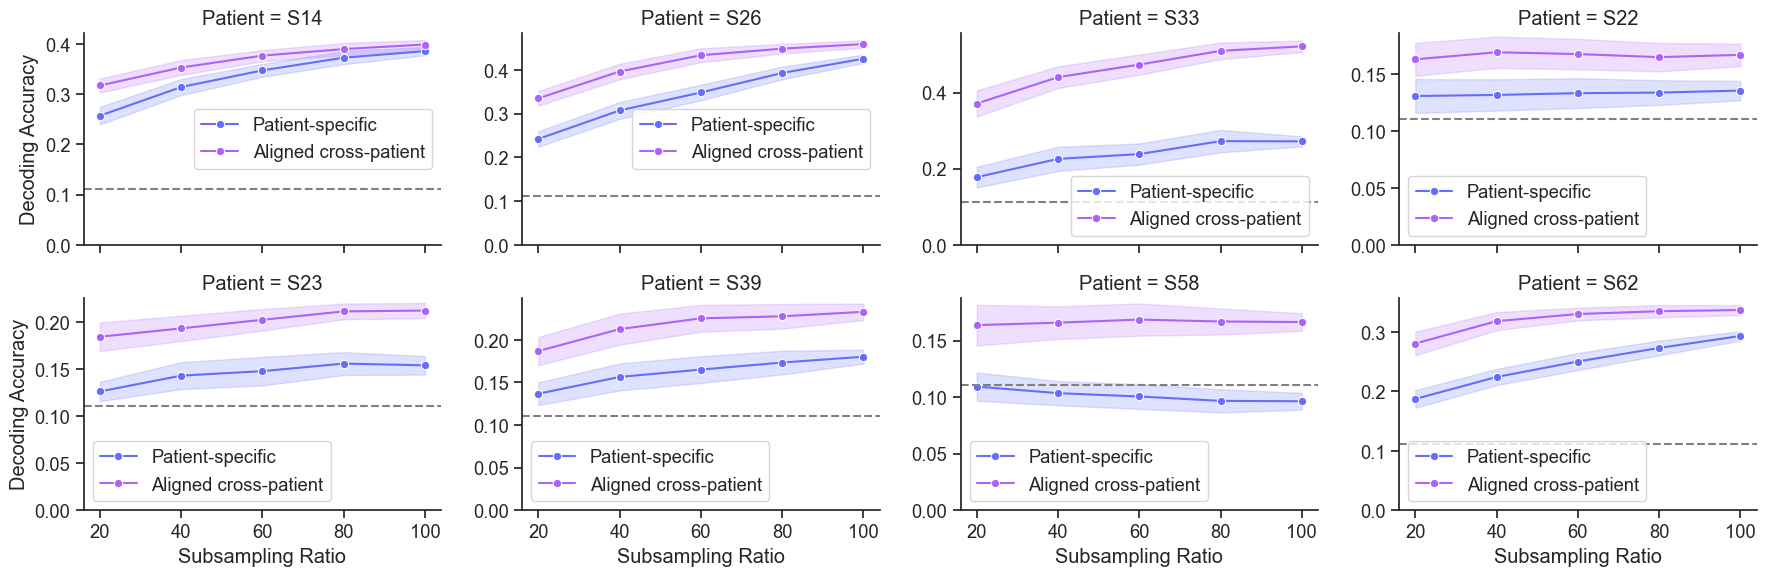

In [113]:
g = sns.FacetGrid(tss_df_long, col='Patient', col_wrap=4, height=3, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'Subsampling Ratio', 'Decoding Accuracy', 'Decoding Context', marker='o', errorbar='sd', palette=['#636EFA', '#AB63FA'])

for g_ax in g.axes:
    g_ax.axhline(1/9, color='grey', linestyle='--')
    g_ax.set_ylim(0, None)
    g_ax.legend()

sns.despine()
plt.show()

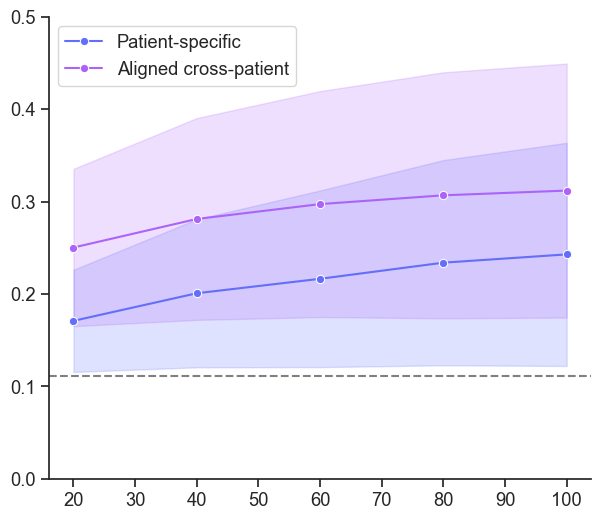

In [298]:
plt.subplots(1,1,figsize=(7,6))

fig_df = tss_df_long[tss_df_long['Phoneme Index'] == 'pAll'].drop(columns=['Phoneme Index']).groupby(['Subsampling Ratio', 'Decoding Context', 'Patient'], sort=False).mean().reset_index()

sns.lineplot(data=fig_df, x='Subsampling Ratio', y='Decoding Accuracy', hue='Decoding Context', marker='o', errorbar='sd', palette=['#636EFA', '#AB63FA'])
plt.axhline(1/9, color='grey', linestyle='--')
# plt.title('Decoding Accuracy by Target Subsampling Ratio')
plt.xlabel('')
plt.ylabel('')
plt.ylim(0.05, 0.5)
plt.yticks(np.arange(0, 0.55, 0.1))
plt.legend(loc='upper left')

sns.despine()
# plt.savefig(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\trial_subsampling.svg")
plt.show()

In [122]:
def diff_stat(a,b,axis):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

stat_data = []
for tss in tss_list:
    pt_spf = tss_df_long[(tss_df_long['Decoding Context'] == 'Patient-specific') & (tss_df_long['Subsampling Ratio'] == tss)]['Decoding Accuracy']
    cca = tss_df_long[(tss_df_long['Decoding Context'] == 'Aligned cross-patient') & (tss_df_long['Subsampling Ratio'] == tss)]['Decoding Accuracy']

    res = stats.permutation_test((pt_spf, cca), diff_stat, vectorized=True)
    stat_data.append((tss, res.statistic, res.pvalue))

fdr_pass, fdr_pvals = fdrcorrection([p_val for _, _, p_val in stat_data])
print(fdr_pass)
for i in range(len(stat_data)):
    print(f'Subsampling Ratio: {stat_data[i][0]} - statistic: {stat_data[i][1]}, p-value: {stat_data[i][2]}, FDR-corrected p-value: {fdr_pvals[i]}')

[ True  True  True  True  True]
Subsampling Ratio: 20 - statistic: -0.079344138155938, p-value: 0.0002, FDR-corrected p-value: 0.0002
Subsampling Ratio: 40 - statistic: -0.08038406650394456, p-value: 0.0002, FDR-corrected p-value: 0.0002
Subsampling Ratio: 60 - statistic: -0.08085727036583634, p-value: 0.0002, FDR-corrected p-value: 0.0002
Subsampling Ratio: 80 - statistic: -0.07288258705400519, p-value: 0.0002, FDR-corrected p-value: 0.0002
Subsampling Ratio: 100 - statistic: -0.06906440496789276, p-value: 0.0002, FDR-corrected p-value: 0.0002


### Panel d

In [299]:
pt_spf_accs = []
wide_dfs = []
long_dfs = []
for pt in pt_list:
    ptSpf_acc = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'ptSpecific/{pt}/{pt}_pAll_ptSpecific_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])

    data_tar = utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/pooled_subsampling/{pt}_pAll_poolSamp_ccaAligned_rbf_noCV.pkl')
    acc_mat_tar = data_tar['acc_mat']
    trial_vec_tar = data_tar['trial_vec']
    cps_tar_df = pd.DataFrame(acc_mat_tar.T, columns=trial_vec_tar)
    wide_dfs.append(cps_tar_df)
    cps_tar_df = pd.melt(cps_tar_df, var_name='Cross-patient trials', value_name='Decoding Accuracy')
    cps_tar_df['Patient'] = paper_pt_dict[pt]
    long_dfs.append(cps_tar_df)

    pt_spf_accs.append(np.mean(ptSpf_acc))

cps_df_wide = pd.concat(wide_dfs)
cps_df_long = pd.concat(long_dfs)

In [305]:
cps_df_long

,Cross-patient trials,Decoding Accuracy,Patient
0,35,0.367677,S1
1,35,0.375319,S1
2,35,0.376920,S1
3,35,0.378024,S1
4,35,0.379147,S1
...,...,...,...
895,2692,0.290135,S8
896,2692,0.303433,S8
897,2692,0.317368,S8
898,2692,0.312152,S8


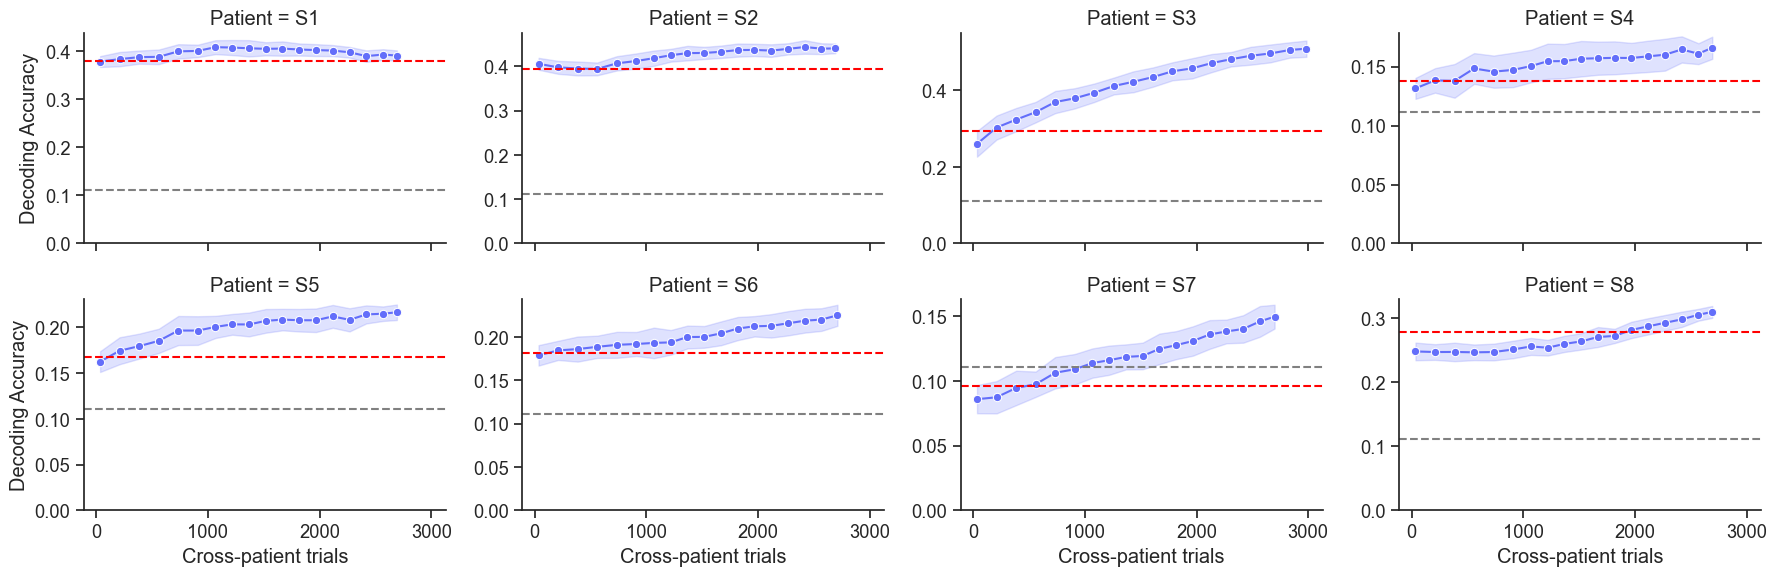

In [ ]:
g = sns.FacetGrid(cps_df_long, col='Patient', col_wrap=4, height=3, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'Cross-patient trials', 'Decoding Accuracy', marker='o', errorbar='sd')

for i, g_ax in enumerate(g.axes):
    g_ax.axhline(1/9, color='grey', linestyle='--')
    g_ax.axhline(pt_spf_accs[i], color='red', linestyle='--')
    g_ax.set_ylim(0, None)

sns.despine()
plt.show()

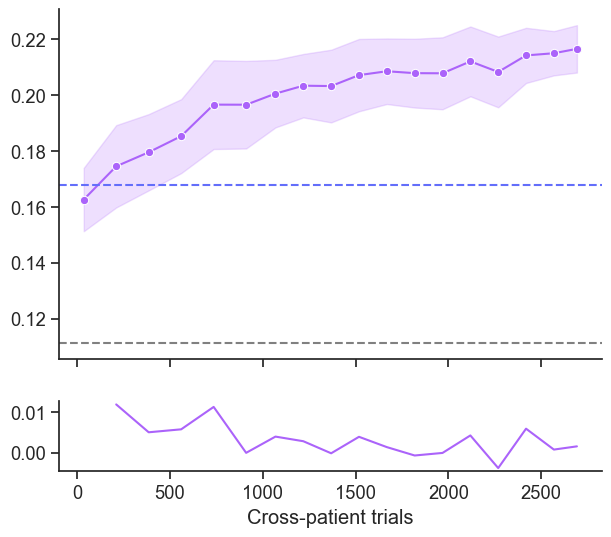

In [269]:
fig_df = cps_df_long[cps_df_long['Patient'] == 'S5']
mean_fig_df = fig_df.drop(columns=['Patient']).groupby('Cross-patient trials').mean().reset_index()
diff_trials = mean_fig_df['Cross-patient trials'].values[1:]
diff_acc = np.diff(mean_fig_df['Decoding Accuracy'].values)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,6), height_ratios=[5,1])

sns.lineplot(data=fig_df, x='Cross-patient trials', y='Decoding Accuracy', marker='o', errorbar='sd', ax=ax1, color='#AB63FA')
ax1.axhline(1/9, color='grey', linestyle='--')
ax1.axhline(np.mean(pt_spf_accs[4]), color='#636EFA', linestyle='--')
ax1.set_xlabel('')
ax1.set_ylabel('')

sns.lineplot(x=diff_trials, y=diff_acc, ax=ax2, color='#AB63FA')
ax2.set_xlabel('Cross-patient trials')


sns.despine()
plt.savefig(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\cross_pt_subsampling_S5.svg")
plt.show()

### Panel e

In [308]:
wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        
        p_tar = np.empty((4, 50))
        p_tar[:] = np.nan

        # SVM accuracies
        p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'ptSpecific/{pt}/{pt}_{p_str}_ptSpecific_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_{p_str}_pooled_ccaAlignedNew_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])

        # RNN accuracies
        ptSpf_rnn_accs = np.load(DATA_PATH + f'ptSpecific/{pt}/{pt}_ptSpecific_seq2seq_rnn_accs.npy').mean(axis=1)
        p_tar[2,:len(ptSpf_rnn_accs)] = ptSpf_rnn_accs
        algn_rnn_accs = np.load(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_pooled_seq2seq_rnn_accs.npy').mean(axis=1)
        p_tar[3,:len(algn_rnn_accs)] = algn_rnn_accs

        decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific_SVM', 'Aligned cross-patient_SVM', 'Patient-specific_RNN', 'Aligned cross-patient_RNN'])


        wide_dfs.append(decode_df)
        decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='accuracy')
        decode_df['Model'] = decode_df['Decoding Context'].apply(lambda x: x.split('_')[1])
        decode_df['Decoding Context'] = decode_df['Decoding Context'].apply(lambda x: x.split('_')[0])
        decode_df['Patient'] = paper_pt_dict[pt]
        cols = decode_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        decode_df = decode_df[cols]
        long_dfs.append(decode_df)
        
rnn_df_wide = pd.concat(wide_dfs)
rnn_df_long = pd.concat(long_dfs)

rnn_df_long = rnn_df_long.dropna()

In [309]:
rnn_df_long

,Patient,Decoding Context,accuracy,Model
0,S1,Patient-specific,0.398148,SVM
1,S1,Patient-specific,0.388889,SVM
2,S1,Patient-specific,0.379630,SVM
3,S1,Patient-specific,0.365741,SVM
4,S1,Patient-specific,0.370370,SVM
...,...,...,...,...
165,S8,Aligned cross-patient,0.244213,RNN
166,S8,Aligned cross-patient,0.295370,RNN
167,S8,Aligned cross-patient,0.265509,RNN
168,S8,Aligned cross-patient,0.286343,RNN


In [313]:
fig_df = rnn_df_long[rnn_df_long['Patient'] == 'S5']
fig = px.box(fig_df, x='Model', y="accuracy", color='Decoding Context', points='all', width=600, height=500, color_discrete_sequence=['#636EFA', '#AB63FA'])
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    title_text='',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='Decoding model',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Phoneme decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)

# fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_4\rnn_decoding_S5.svg")
fig.show()

In [ ]:
pt='S5'
stat_df = rnn_df_long[rnn_df_long['Patient'] == 'S5'].drop(columns=['Patient']).rename(columns={'Decoding Context': 'context'})

model = ols('accuracy ~ C(context) + C(Model) + C(context):C(Model)', data=stat_df).fit()
anova2way_res = anova_lm(model, typ=2)
print('##### 2-way ANOVA results #####')
print(anova2way_res)

pt_spf_svm = rnn_df_long[(rnn_df_long['Patient'] == pt) & (rnn_df_long['Decoding Context'] == 'Patient-specific') & (rnn_df_long['Model'] == 'SVM')]['accuracy']
cca_svm = rnn_df_long[(rnn_df_long['Patient'] == pt) & (rnn_df_long['Decoding Context'] == 'Aligned cross-patient') & (rnn_df_long['Model'] == 'SVM')]['accuracy']
pt_spf_rnn = rnn_df_long[(rnn_df_long['Patient'] == pt) & (rnn_df_long['Decoding Context'] == 'Patient-specific') & (rnn_df_long['Model'] == 'RNN')]['accuracy']
cca_rnn = rnn_df_long[(rnn_df_long['Patient'] == pt) & (rnn_df_long['Decoding Context'] == 'Aligned cross-patient') & (rnn_df_long['Model'] == 'RNN')]['accuracy']

print('##### Follow-up t-tests ######')
tukey_res = stats.tukey_hsd(pt_spf_svm, cca_svm, pt_spf_rnn, cca_rnn)
print(tukey_res)
cca_ps_svm_p = res.pvalue[1,0]

##### 2-way ANOVA results #####
                       sum_sq     df           F        PR(>F)
C(context)           0.052280    1.0  214.284091  9.980904e-30
C(Model)             0.096436    1.0  395.269642  4.536622e-42
C(context):C(Model)  0.006262    1.0   25.665370  1.298263e-06
Residual             0.033181  136.0         NaN           NaN
##### Follow-up t-tests ######
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.047     0.000    -0.055    -0.039
 (0 - 2)     -0.073     0.000    -0.084    -0.062
 (0 - 3)     -0.090     0.000    -0.101    -0.080
 (1 - 0)      0.047     0.000     0.039     0.055
 (1 - 2)     -0.026     0.000    -0.037    -0.015
 (1 - 3)     -0.043     0.000    -0.054    -0.033
 (2 - 0)      0.073     0.000     0.062     0.084
 (2 - 1)      0.026     0.000     0.015     0.037
 (2 - 3)     -0.017     0.003    -0.030    -0.005
 (3 - 0)      0.090     0.000     0.080     0.101
 (3 